# Firefly Algorithm for Traveling Salesman Problem (MK)

The Firefly Algorithm is a nature inspired optimization algorithm that is based on the behavior of fireflies in nature. Each firefly represents a possible solution to the optimization problem, and its brightness corresponds to the quality of that solution. Brighter fireflies attract others, meaning that worse solutions move toward better ones during the optimization process.

The algorithm combines two important ideas:
- Attraction toward better solutions, which helps improve solution quality,
- Random movement, which helps explore the search space and avoid getting stuck in local optima.

Because of this balance between exploration and exploitation, the Firefly Algorithm is suitable for complex optimization problems such as the Traveling Salesman Problem

---

# Data loading and Problem Representation 

The first step of this project is to load and prepare the dataset that defines the Traveling Salesman Problem. The dataset consists of a real world travel time matrix between selected tourist cities in North Macedonia, as well as their geographic coordinates (latitude and longitude).

The goal of this step is to:

- Define the problem instance clearly,

- Ensure that all cities are aligned between the time matrix and coordinate data,

- Enable both optimization and visualization of the resulting routes.

Each city represents a node in the TSP, and the travel time matrix defines the cost of traveling between any two cities.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import pandas as pd

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

cities_matrix = pd.read_csv(
    "../data/macedonia_travel_time_matrix_all_cities_only.csv",
    index_col=0
)

cities_cords = pd.read_csv("../data/mk.csv")
cities_cords.columns = cities_cords.columns.str.replace("\ufeff", "", regex=False).str.strip()
cities_cords = cities_cords[["city", "lat", "lng"]].copy()
cities_cords = cities_cords[cities_cords["city"].isin(cities_matrix.columns)].copy()
cities_cords = cities_cords.set_index("city").loc[cities_matrix.columns].reset_index()
cities_cords = cities_cords.rename(columns={"index": "city"})

distance_matrix = cities_matrix.values
n_cities = distance_matrix.shape[0]
city_names = cities_cords["city"].tolist()

cities = cities_cords[["lng", "lat"]].values

The travel time matrix is loaded from a CSV file and converted into a NumPy matrix, which is later used by the optimization algorithm. City coordinates are also loaded and filtered so that only the cities present in the time matrix are included. The coordinates are reordered to match the order of cities in the matrix.

This ensures consistency between:

- City indices used in the algorithm,

- City names,

- Geographic coordinates used for plotting.

A scatter plot of the cities is generated to visually verify the spatial distribution of the problem.

In [3]:
assert len(city_names) == n_cities
assert cities.shape[0] == n_cities

In [4]:
print(cities_cords.columns.tolist())
print(cities_cords.head())

['city', 'lat', 'lng']
       city      lat      lng
0    Skopje  41.9961  21.4317
1  Kumanovo  42.1322  21.7144
2    Bitola  41.0319  21.3347
3    Prilep  41.3464  21.5542
4    Tetovo  42.0103  20.9714


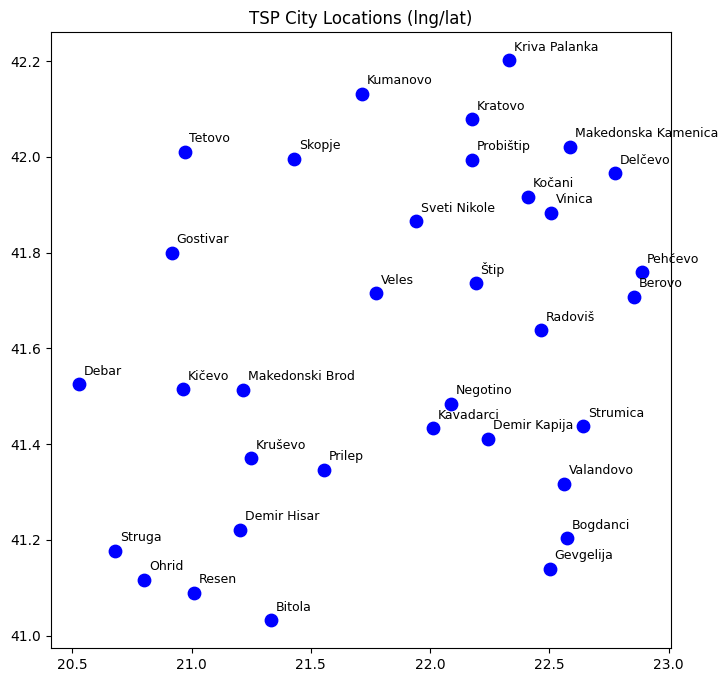

In [5]:
plt.figure(figsize=(8, 8))
plt.scatter(cities_cords["lng"], cities_cords["lat"], c="blue", s=80)

for _, row in cities_cords.iterrows():
    plt.text(row["lng"] + 0.02, row["lat"] + 0.02, row["city"], fontsize=9)

plt.title("TSP City Locations (lng/lat)")
plt.show()

In [6]:
def plot_tour(coords, tour, city_names, title="Tour"):
    """
    Plots a TSP tour using lng/lat coordinates and city names.
    
    coords      : numpy array of shape (n_cities, 2) -> [lng, lat]
    tour        : list of city indices
    city_names  : list of city names aligned with coords
    """
    closed_tour = tour + [tour[0]]
    ordered_coords = coords[closed_tour]
    ordered_names = [city_names[i] for i in closed_tour]

    plt.figure(figsize=(8, 8))
    
    plt.plot(
        ordered_coords[:, 0],
        ordered_coords[:, 1],
        "-o",
        linewidth=2,
        markersize=6
    )

    for (x, y), name in zip(ordered_coords, ordered_names):
        plt.text(x + 0.02, y + 0.02, name, fontsize=9)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [7]:
T = distance_matrix      
coords = cities           
names = city_names          

----

# Firefly algorithm setup

Before running the Firefly Algorithm, a set of helper functions is defined to support the optimization process. These functions describe how solutions are represented, evaluated, and modified during the search. Their role is to translate the abstract idea of the Firefly Algorithm into operations that work on permutations of cities.

A route cost function is used to calculate the total travel time of a tour, including the return to the starting city. Fireflies are initialized as random permutations of cities, ensuring that each initial solution is valid. In order to guide the attraction mechanism of the algorithm, a distance measure between two routes is defined based on positional differences in city order. This allows the algorithm to determine how similar or different two solutions are.

Movement operators are also introduced to modify routes during the optimization. Attraction based swaps allow worse solutions to move toward better ones, while random inversion introduces controlled randomness. This balance between structured movement and randomness is essential for maintaining diversity in the population and avoiding premature convergence.

In [8]:
def route_cost(route, time_matrix):
    cost = 0.0
    for i in range(len(route) - 1):
        cost += time_matrix[route[i], route[i+1]]
    cost += time_matrix[route[-1], route[0]]
    return float(cost)

In [9]:
def initialize_fireflies(n_fireflies, n_cities):
    fireflies = []
    for _ in range(n_fireflies):
        r = list(range(n_cities))
        random.shuffle(r)
        fireflies.append(r)
    return fireflies

In [10]:
def route_distance(r1, r2):
    n = len(r1)
    return sum(1 for i in range(n) if r1[i] != r2[i]) / n

In [11]:
def random_inversion(route):
    a, b = sorted(random.sample(range(len(route)), 2))
    new = route.copy()
    new[a:b+1] = list(reversed(new[a:b+1]))
    return new

In [12]:
def move_firefly(route_i, route_j, beta):
    new_route = route_i.copy()
    for k in range(len(route_i)):
        if route_i[k] != route_j[k] and random.random() < beta:
            idx = new_route.index(route_j[k])
            new_route[k], new_route[idx] = new_route[idx], new_route[k]
    return new_route

---

# Baseline Firefly Algorithm

In this phase, the baseline Firefly Algorithm is applied to the Traveling Salesman Problem using fixed parameters and without any local optimization techniques. The purpose of this experiment is to evaluate how well the Firefly Algorithm performs on its own when solving the problem.

During the optimization process, fireflies repeatedly compare their solutions and move toward brighter (better) ones. At the same time, a decreasing randomness factor allows the algorithm to explore different regions of the search space early on, while gradually focusing on exploitation in later iterations. The convergence plot shows how the best solution improves over time.

In [13]:
def firefly_algorithm(
    time_matrix,
    n_fireflies=25,
    max_iter=300,
    beta0=1.0,
    gamma=2.0,
    alpha0=0.4,
    seed=0
):
    random.seed(seed)
    np.random.seed(seed)

    n_cities = time_matrix.shape[0]
    fireflies = initialize_fireflies(n_fireflies, n_cities)

    best_route = None
    best_cost = float("inf")
    history = []

    for t in range(max_iter):
        alpha = alpha0 * (0.97 ** t)
        costs = [route_cost(r, time_matrix) for r in fireflies]

        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if costs[j] < costs[i]:
                    dist = route_distance(fireflies[i], fireflies[j])
                    beta = beta0 * np.exp(-gamma * dist**2)

                    cand = move_firefly(fireflies[i], fireflies[j], beta)

                    if random.random() < alpha:
                        cand = random_inversion(cand)

                    cand_cost = route_cost(cand, time_matrix)

                    if cand_cost < costs[i]:
                        fireflies[i] = cand
                        costs[i] = cand_cost

        idx = int(np.argmin(costs))
        if costs[idx] < best_cost:
            best_cost = costs[idx]
            best_route = fireflies[idx].copy()

        history.append(best_cost)

    return best_route, best_cost, history

In [15]:
best_route_base, best_cost_base, history_base = firefly_algorithm(
    T,
    seed=1
)

print("Baseline Firefly")
print("Best cost: ", best_cost_base)

Baseline Firefly
Best cost:  2109.9


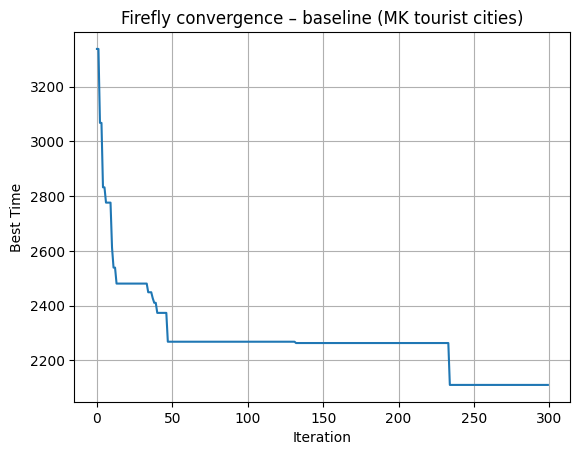

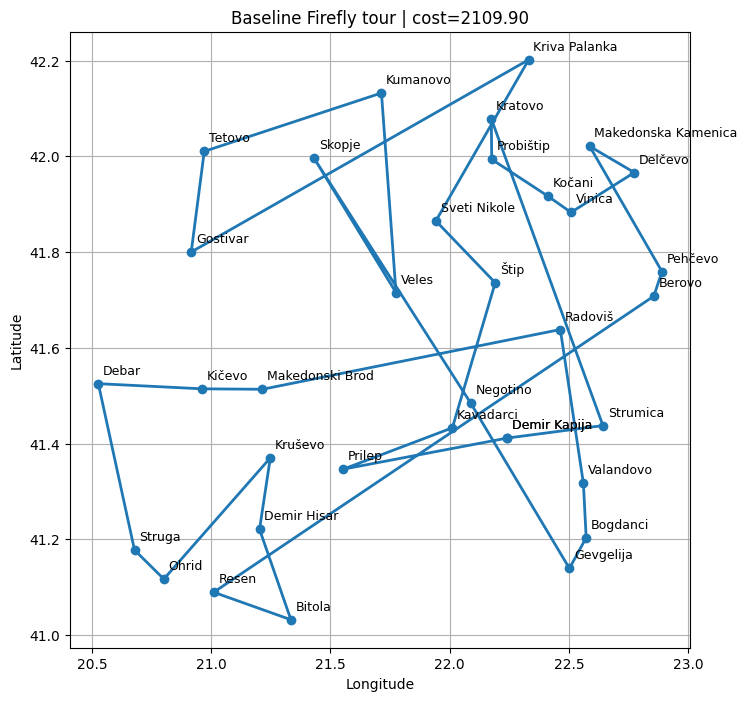

In [16]:
plt.figure()
plt.plot(history_base)
plt.xlabel("Iteration")
plt.ylabel("Best Time")
plt.title("Firefly convergence – baseline (MK tourist cities)")
plt.grid(True)
plt.show()

plot_tour(
    coords,
    best_route_base,
    names,
    title=f"Baseline Firefly tour | cost={best_cost_base:.2f}"
)

The results indicate that the algorithm quickly reduces the travel cost during the early iterations, followed by a slower improvement phase. The final best cost obtained by the baseline Firefly Algorithm is approximately 2109.9. Although the resulting tour is valid, it still contains inefficient connections and route crossings, which suggests that the solution is not locally optimal.

The baseline Firefly Algorithm is effective at global exploration and significantly improves the initial random solutions. However, without local refinement, it converges to a solution that still contains local inefficiencies.

---

# Baseline Firefly with 2-opt Local Search

To further improve the baseline solution, a 2-opt local search algorithm is applied to the best route found by the Firefly Algorithm. The idea behind this step is to refine the solution by removing unnecessary crossings and reducing local detours, while keeping the overall structure discovered by the global search.

The 2-opt algorithm works deterministically by iteratively reversing segments of the tour whenever this leads to a shorter total travel time. This process continues until no further local improvements can be found. Unlike the Firefly Algorithm, this step does not rely on randomness and focuses purely on local optimization.

In [17]:
def two_opt(route, T):
    best = route.copy()
    best_cost = route_cost(best, T)
    improved = True

    while improved:
        improved = False
        for i in range(1, len(best) - 2):
            for j in range(i + 1, len(best)):
                if j - i == 1:
                    continue
                cand = best.copy()
                cand[i:j] = list(reversed(cand[i:j]))
                cand_cost = route_cost(cand, T)
                if cand_cost < best_cost:
                    best = cand
                    best_cost = cand_cost
                    improved = True
    return best, best_cost

In [20]:
best_route_2opt, best_cost_2opt = two_opt(best_route_base, T)

print("Baseline Firefly with 2-opt local search")
print("Best cost: ", best_cost_2opt)

Baseline Firefly with 2-opt local search
Best cost:  1343.2000000000003


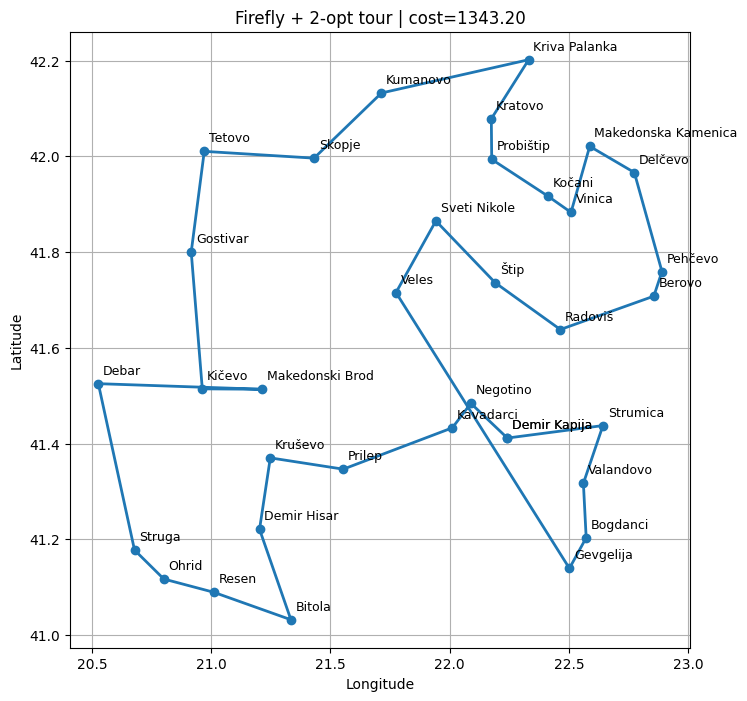

In [21]:
plot_tour(
    coords,
    best_route_2opt,
    names,
    title=f"Firefly + 2-opt tour | cost={best_cost_2opt:.2f}"
)

After applying 2-opt, the travel cost is significantly reduced to approximately 1343.2. The resulting route is noticeably smoother and more geographically consistent, demonstrating that many of the inefficiencies in the baseline solution were local in nature.

The application of 2-opt shows that local search is highly effective at refining solutions produced by the Firefly Algorithm. Combining global exploration with local optimization leads to a substantial improvement in solution quality.

---

# Parameter Tuning 

In the final phase of the project, parameter tuning is performed to further enhance the performance of the Firefly Algorithm. Different values for key parameters, such as the number of fireflies, attractiveness, randomness, and absorption coefficient, are tested using a grid search approach. For each parameter combination, the Firefly Algorithm is executed and the resulting solution is refined using 2-opt.

The goal of this step is to identify a parameter configuration that provides the best balance between exploration and exploitation for this specific dataset. The results show that several parameter combinations achieve similar performance, indicating that the algorithm is relatively stable.

In [22]:
def run_firefly_plus_2opt(time_matrix, n_fireflies, max_iter, beta0, gamma, alpha0, seed=0):
    r, c, _ = firefly_algorithm(
        time_matrix,
        n_fireflies=n_fireflies,
        max_iter=max_iter,
        beta0=beta0,
        gamma=gamma,
        alpha0=alpha0,
        seed=seed
    )
    return two_opt(r, time_matrix)

In [ ]:
grid_n_fireflies = [25, 40]
grid_beta0 = [0.8, 1.0]
grid_gamma = [1.0, 2.0, 4.0]
grid_alpha0 = [0.2, 0.4, 0.6]
grid_max_iter = [300]

rows = []
best_cost_tuned = float("inf")
best_route_tuned = None
best_cfg = None

for nf in grid_n_fireflies:
    for b0 in grid_beta0:
        for g in grid_gamma:
            for a0 in grid_alpha0:
                for it in grid_max_iter:
                    r2, c2 = run_firefly_plus_2opt(
                        T, nf, it, b0, g, a0, seed=0
                    )

                    rows.append({
                        "n_fireflies": nf,
                        "beta0": b0,
                        "gamma": g,
                        "alpha0": a0,
                        "max_iter": it,
                        "cost": float(c2)
                    })

                    if c2 < best_cost_tuned:
                        best_cost_tuned = c2
                        best_route_tuned = r2
                        best_cfg = (nf, b0, g, a0, it)

grid_df = pd.DataFrame(rows).sort_values("cost").reset_index(drop=True)


In [24]:
print("Parametar tuning (Firefly with 2-opt local search)")
print("Best config: ", best_cfg)
print("Best cost: ", best_cost_tuned)

Parametar tuning (Firefly with 2-opt local search)
Best config:  (25, 1.0, 2.0, 0.2, 300)
Best cost:  1272.9999999999998


In [25]:
display(grid_df.head(10))

,n_fireflies,beta0,gamma,alpha0,max_iter,cost
0,25,1.0,2.0,0.2,300,1273.0
1,40,0.8,4.0,0.6,300,1273.0
2,40,0.8,4.0,0.4,300,1281.6
3,40,1.0,1.0,0.6,300,1284.0
4,25,0.8,2.0,0.4,300,1284.0
5,25,0.8,4.0,0.6,300,1298.5
6,40,0.8,2.0,0.2,300,1298.8
7,25,1.0,4.0,0.6,300,1307.6
8,25,0.8,4.0,0.2,300,1308.0
9,25,0.8,1.0,0.2,300,1312.5


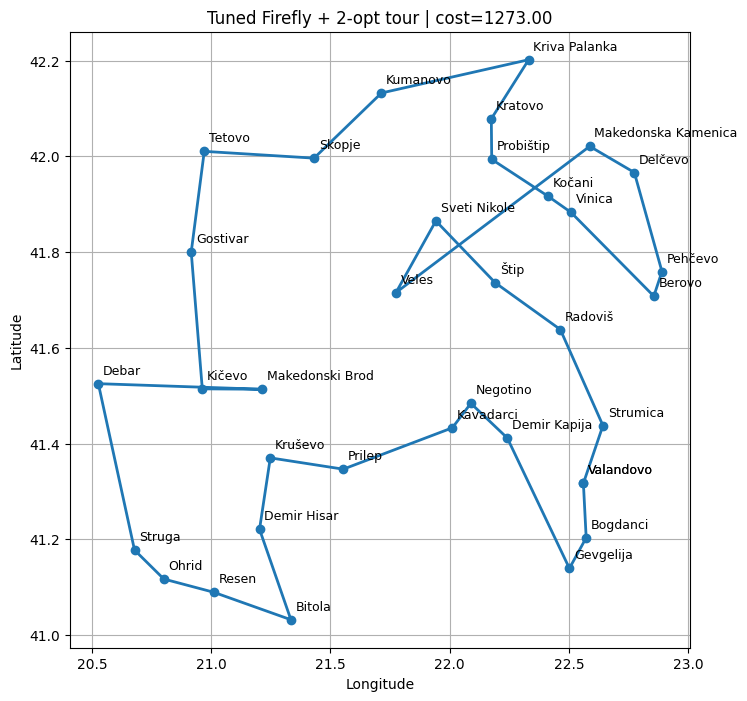

In [26]:
plot_tour(
    coords,
    best_route_tuned,
    names,
    title=f"Tuned Firefly + 2-opt tour | cost={best_cost_tuned:.2f}"
)

The best configuration found uses 25 fireflies, β₀ = 1.0, γ = 2.0, and α₀ = 0.2, with a total of 300 iterations. This configuration produces a best travel cost of approximately 1273.0, which is an improvement over both the baseline and the baseline combined with 2-opt.

Parameter tuning leads to additional improvements by optimizing the behavior of the Firefly Algorithm. When combined with 2-opt, the tuned algorithm produces the most efficient route among all tested configurations.

---

# Overall conclusion

The results show that the Firefly Algorithm is able to solve the Traveling Salesman Problem and produce valid routes for a real world dataset of tourist cities. The baseline implementation provides good global exploration but converges to solutions with noticeable local inefficiencies. Applying 2-opt significantly improves the solution by refining local structure, while parameter tuning leads to additional performance gains.

However, when compared to other metaheuristic approaches tested on the same dataset, such as Particle Swarm Optimization and Ant Colony Optimization, the Firefly based approach performs worse overall. Even after local search and parameter tuning, Firefly achieves higher final travel costs than the other methods. This indicates that Firefly is less suitable for this specific problem instance, especially when strong local optimization is required.

Despite this, the Firefly Algorithm remains useful from an educational perspective and clearly demonstrates the importance of combining global search with local refinement. The experiments highlight that different metaheuristics perform differently depending on the problem, and that hybrid approaches are often necessary to achieve good results.